## **BASIC REGRESSION USING NEURAL NETWORK**

### ***IN THIS PROJECT, WE HAVE TO PREDICT FUEL EFFICIENCY***

In a regression problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a classification problem, where we aim to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This notebook uses the classic Auto MPG Dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. To do this, we'll provide the model with a description of many automobiles from that time period. This description includes attributes like: cylinders, displacement, horsepower, and weight on the basis of which it will predict the fuel efficiency.


https://archive.ics.uci.edu/ml/datasets/auto+mpg




**IMPORTING LIBRARIES**

In [316]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
#####
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


**CHECKING PYTHON VERSION**

In [317]:
print(tf.__version__)

2.3.0


**IMPORTING DATASET FROM url**

In [318]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight','Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)


**CREATING A COPY OF DATA AND VIEWING IT**

In [319]:
dataset=raw_dataset.copy()
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


**DATA CLEANING**

*1) CHECKING IF THERE IS ANY NULL VALUE*

In [320]:
dataset.isna().sum()    # we have  null values in column Horsepower

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

*2) REPLACING NULL VALUES BY DROPPING IT*

In [321]:
dataset=dataset.dropna()
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

*3) SINCE THE "ORIGIN" COLUMN IN DATA IS CATEGORICAL,NOT NUMERIC. SO WE HAVE TO CONVERT IT USING ONE HOT ENCODING TECHNIQUE*




In [322]:
#mapping data
dataset['Origin']=dataset['Origin'].map({1:'USA', 2:'Europe', 3:'Japan'})  
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,USA
394,44.0,4,97.0,52.0,2130.0,24.6,82,Europe
395,32.0,4,135.0,84.0,2295.0,11.6,82,USA
396,28.0,4,120.0,79.0,2625.0,18.6,82,USA
397,31.0,4,119.0,82.0,2720.0,19.4,82,USA


In [323]:
# creating separate columns for each mapped data i.e. ONE-HOT-ENCODING
dataset=pd.get_dummies(dataset,prefix='',prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


**SPLITTING DATA INTO TRAIN AND TEST MANUALLY**

In [324]:
# 0.8 means 80 of data will be train data with random number seed value = 0
# random_state simply sets a seed to the random generator, so that your train-test splits are always deterministic. If you don't set a seed, it is different each time.

train_dataset=dataset.sample(frac=0.8,random_state=0) 
test_dataset=dataset.drop(train_dataset.index) # it will bw the remaining data except train_dataset

**PREPARING DATA**

*1) INSPECT DATA(DATA VISUALIZATION)*

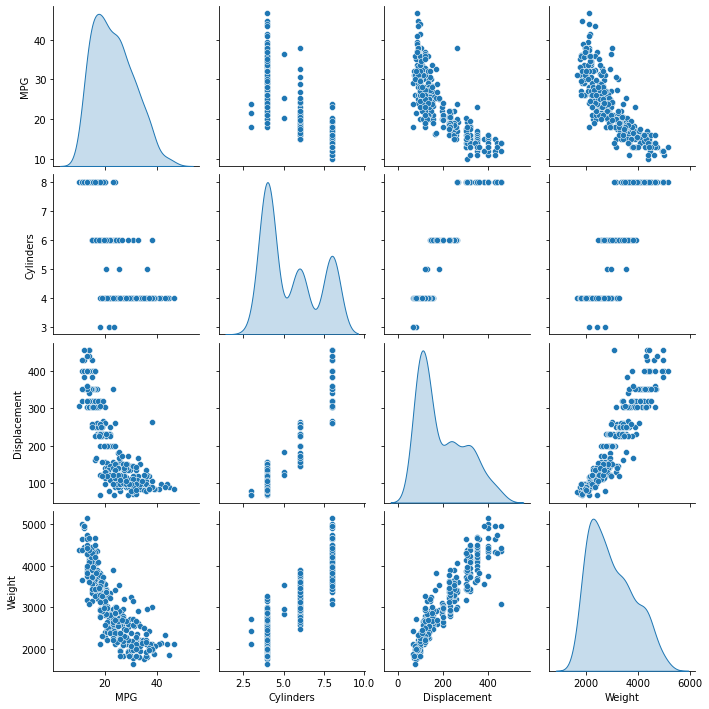

In [325]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']],diag_kind='kde')

*2) SEPARATE 'MPG' FROM DATA AS THIS IS THE VALUE THAT YOU WILL TRAIN TO PREDICT THE MODEL*





In [326]:
# creating copy of train and test dataset 
train_features=train_dataset.copy()
test_features=test_dataset.copy()

# popping the MPG column from copied data set(features)
# The pop() method removes the last element from an array and returns that element.
train_labels=train_features.pop('MPG')
test_labels=test_features.pop('MPG')

*3) VIEWING DIFFERENCES AFTER USING POP FUNCTION*

In [327]:
train_features.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,4,97.0,67.0,2145.0,18.0,80,0,1,0


In [328]:
test_features.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
9,8,390.0,190.0,3850.0,8.5,70,0,0,1
25,8,360.0,215.0,4615.0,14.0,70,0,0,1
28,8,304.0,193.0,4732.0,18.5,70,0,0,1
31,4,113.0,95.0,2228.0,14.0,71,0,1,0
33,6,232.0,100.0,2634.0,13.0,71,0,0,1


In [329]:
train_labels.head()

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
Name: MPG, dtype: float64

In [330]:
test_labels.head()

9     15.0
25    10.0
28     9.0
31    25.0
33    19.0
Name: MPG, dtype: float64

*4) USING DESCRIBE FUNCTION TO CHECK DATA*

In [331]:

train_dataset.describe().transpose()[['mean','std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


*AS THE STATISTICS SHOWS DIFFERENT RANGES OF EACH FEATURES, THEREFORE, WE NEED TO NORMALIZE DATA*


**DATA NORMALIZATION**

In [332]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features)) 
# This calculates the mean and variance, and stores them in the layer.

In [333]:
#this cell is not necessary.
print(normalizer.mean.numpy())

[5.4777069e+00 1.9531847e+02 1.0486943e+02 2.9902517e+03 1.5559236e+01
 7.5898087e+01 1.7834395e-01 1.9745223e-01 6.2420380e-01]


In [334]:
#this cell is not necessary.
# When the layer is called it returns the input data, with each feature independently normalized:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())
  


First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


# **LINEAR REGRESSION**

## **a) ONE VARIABLE (SINGLE INPUT)**

Start with a single-variable linear regression, to predict MPG from Horsepower.

In this case there are two steps:

1) Normalize the input horsepower.

2) Apply a linear transformation ($y = mx+b$) to produce 1 output using layers.Dense.


**NORMALIZING HORSEPOWER**

In [335]:
horsepower = np.array(train_features['Horsepower'])
horsepower_normalizer = preprocessing.Normalization(input_shape=[1,])
horsepower_normalizer.adapt(horsepower)

**BUILDING SEQUENCIAL MODEL**

In [336]:
horsepower_model=tf.keras.Sequential([horsepower_normalizer,layers.Dense(units=1)])
horsepower_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_16 (Normalizat (None, 1)                 3         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


**PREDICTING**

This model will predict MPG from Horsepower.

Run the untrained model on the first 10 horse-power values. The output won't be good, but you'll see that it has the expected shape, (10,1):



In [337]:
horsepower_model.predict(horsepower[:10])


array([[-0.16060221],
       [-0.0907037 ],
       [ 0.2964265 ],
       [-0.2251239 ],
       [-0.20361666],
       [-0.07995008],
       [-0.24125431],
       [-0.20361666],
       [-0.05306604],
       [-0.0907037 ]], dtype=float32)

**MODEL COMPILATION**

In [338]:
horsepower_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),loss='mean_absolute_error')


**FITTING MODEL(TRAINING)**

In [339]:
history = horsepower_model.fit(train_features['Horsepower'], train_labels,epochs=100,verbose=0,validation_split = 0.2)

**VISUALIZING MODEL TRAINING BY USINGS STATS STORED IN HISTORY**

In [340]:
hist=pd.DataFrame(history.history)
hist['epochs']=history.epoch
hist.tail()

,loss,val_loss,epochs
95,3.808701,4.197463,95
96,3.807274,4.165064,96
97,3.805434,4.183801,97
98,3.802207,4.199753,98
99,3.805546,4.186567,99


**PLOTTING RESULTS**

In [341]:
# making a function for poltting
def plot_loss(history):
  plt.plot(history.history['loss'],label='loss')
  plt.plot(history.history['val_loss'],label='val_loss')
  plt.ylim([0,10])
  plt.xlabel('EPOCHS')
  plt.ylabel('ERROR[MPG]')
  plt.legend()
  plt.grid(True)

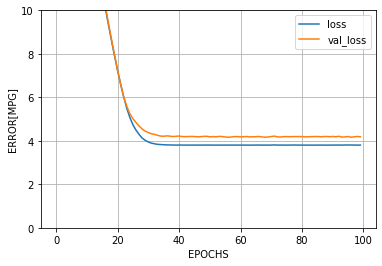

In [342]:
# calling the plotting function
plot_loss(history)

**MODEL EVALUATION AND COLLECTING RESULTS OF TEST SET FOR LATER USE**

In [343]:
# Verbosity in keyword arguments usually means showing more 'wordy' information for the task. 
# In machine learning, by setting verbose to a higher number ( 2 vs 1 ), you may see more information about the tree building process.
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(test_features['Horsepower'],test_labels, verbose=0)

**PREDICTION AND RESULT PLOTTING**

In [344]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [345]:
# DEFINING FUNCTION FOR PLOTTING
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()


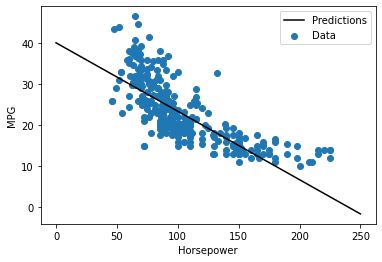

In [346]:
# CALLING FUNCTION OF PLOTTING
plot_horsepower(x,y)


# **b) MULTIPLE INPUTS**

An identical setup to make predictions based on multiple inputs. 
This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

**This time use the Normalization layer that was adapted to the whole dataset**



In [347]:
linear_model=tf.keras.Sequential([normalizer,layers.Dense(units=1)])

**PREDICTION**

In [348]:
linear_model.predict(train_features[:10])


array([[-0.04026913],
       [ 0.05704315],
       [-0.7602026 ],
       [-0.09924622],
       [ 1.6768739 ],
       [ 0.48220783],
       [ 1.9440136 ],
       [ 0.937705  ],
       [ 0.5336995 ],
       [ 1.7100575 ]], dtype=float32)

**COMPILE**

In [349]:
linear_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),loss='mean_absolute_error')

**FIT (TRAIN)**

In [350]:
history = linear_model.fit(train_features,train_labels,epochs=100,verbose=0,validation_split = 0.2)

**RESULT PLOT BY CALLING FUNCTION (line 131)**

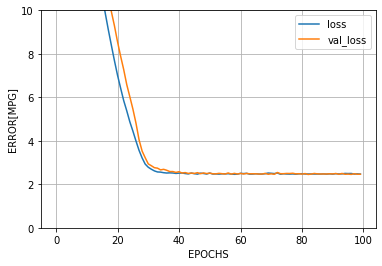

In [351]:
plot_loss(history)

**MODEL EVALUATION AND COLLECTING RESULTS FOR LATER USE**

In [352]:
test_results['linear_model']=linear_model.evaluate(test_features,test_labels,verbose=0)

# **DNN REGRESSION (DNN - DEEP NEURAL NETWORK)**
This section implements single-input and multiple-input DNN models. 
The code is basically the same except the model is expanded to include some "hidden" non-linear layers. 
The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

The normalization layer.
Two hidden, nonlinear, Dense layers using the relu nonlinearity.
A linear single-output layer.
Both will use the same training procedure so the compile method is included in the build_and_compile_model function below.



**BUILDING MODEL**

In [353]:
# DEFINING A FUNCTION OF BULIDING AND COMPILING MODEL
def build_and_compile_model(norm):
  model = keras.Sequential([
  norm,
  layers.Dense(64,activation='relu'),
  layers.Dense(64,activation='relu'),
  layers.Dense(1)])
  model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001))
  return model

# **a) ONE VARIABLE (SINGLE INPUT)**

In [354]:
# CALLING FUNCTION 
dnn_horsepower_model= build_and_compile_model(horsepower_normalizer)
dnn_horsepower_model.summary()


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_16 (Normalizat (None, 1)                 3         
_________________________________________________________________
dense_35 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_36 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


**FIT(TRAIN THE MODEL)**

In [355]:
history=dnn_horsepower_model.fit(train_features['Horsepower'],train_labels,validation_split=0.2,epochs=100,verbose=0)

**PLOT RESULTS**

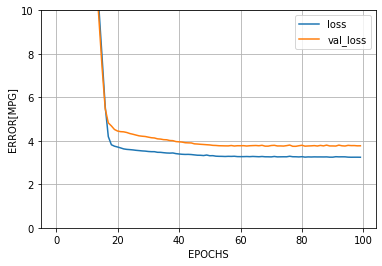

In [356]:
plot_loss(history)

**PREDCITION AND RESULT PLOTTING**

In [357]:
x = tf.linspace(0.0,250,251)
y = dnn_horsepower_model.predict(x)

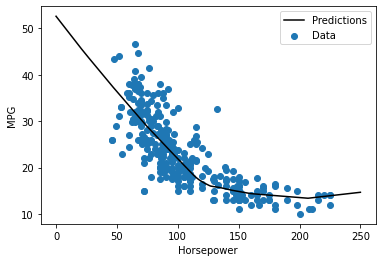

In [358]:
# CALLING FUNCTION FOR PLOTTING DEFINED ON LINE# 182
plot_horsepower(x,y)

**MODEL EVALUATION AND COLLECTING RESULTS FOR LATER USE**

In [359]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(test_features['Horsepower'],test_labels,verbose=0)

## **FULL MODEL**

In [360]:
# CALLING FUNCTION DEFINED  ON LINE# 303
dnn_model=build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_15 (Normalizat (None, 9)                 19        
_________________________________________________________________
dense_38 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_39 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


**FIT (TRAIN THE MODEL)**

In [363]:
history = dnn_model.fit(train_features,train_labels,validation_split=0.2,epochs=100,verbose=0)

**PLOT RESULTS BY CALLING FUNCTION**

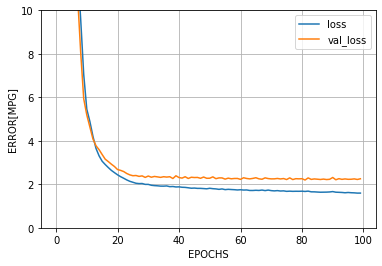

In [364]:
plot_loss(history)

**EVALUATE THE MODEL AND COLLECT DATA FOR LATER USE**

In [365]:
test_results['dnn_model'] = dnn_model.evaluate(test_features,test_labels,verbose=0)

##**PERFORMANCE**

**Now that all the models are trained check the test-set performance and see how they did**



In [366]:
pd.DataFrame(test_results,index=['mean absolute error[MPG]']).T

,mean absolute error[MPG]
horsepower_model,3.648102
linear_model,2.470134
dnn_horsepower_model,2.921604
dnn_model,1.765636


**MAKE PREDICTIONS**

Finally, predict have a look at the errors made by the model when making predictions on the test set:


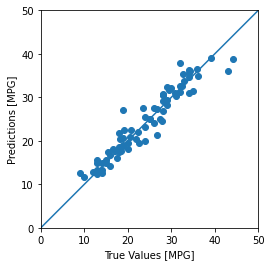

In [368]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


**ERROR DISTRIBUTION VISUALIZATION**

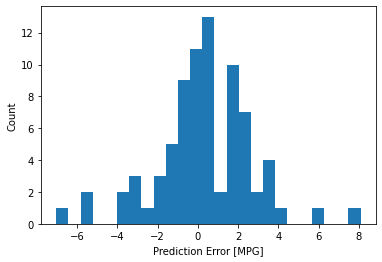

In [369]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')


**SAVE MODEL IF U ARE SATISFIED WITH THE RESULTS**

In [370]:
dnn_model.save('dnn_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: dnn_model/assets


**RELOADING MODEL AGAIN WILL GIVE THE IDENTICAL RESULTS**

In [371]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(test_features, test_labels, verbose=0)


In [372]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.648102
linear_model,2.470134
dnn_horsepower_model,2.921604
dnn_model,1.765636
reloaded,1.765636
